# Neural Network using TensorFlow

### Importing Libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

C:\Users\a_mon\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\a_mon\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\a_mon\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\a_mon\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

###  Neural Network

In [2]:
#neural network class include initalizer and a setup function

class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
        self.L = len(layers) #number of layers
        self.num_features = layers[0] #number of features
        self.num_classes = layers[-1] #number of classes
        
        #dictionaries
        self.W = {} #weights 
        self.b = {} #biases
        
        self.dW = {} #weights gradient
        self.db = {} #biases gradient
        
        self.setup()
        
    def setup(self):
        #initialize values for the paramenter
        for i in range(1, self.L): #starting from the second layer, the layer indexed 1
            #weight is set to an inital random value
            #its shape is the number of nodes in this layer by the number of nodes in the preceding layer
            self.W[i] = tf.Variable(tf.random.normal(shape=(self.layers[i], self.layers[i-1])))
            #we also initialize the bias
            self.b[i] = tf.Variable(tf.random.normal(shape=(self.layers[i], 1)))         
            
    def forward_pass(self, A):
        #the X input, used for activation
        A = tf.convert_to_tensor(A, dtype=tf.float32)
        for i in range(1, self.L): 
            Z = tf.matmul(A,tf.transpose(self.W[i]))+ tf.transpose(self.b[i]) # computing the linear output (W*x+b)
            #we transpose because for example with 200 features and 50 examples the shape of X would be 50x200
           
            #if the layer is not final layer we have an activation function
            #in the final layer we just use the activation function
            if i != self.L-1:
            
               A = tf.nn.relu(Z)
            else:
                A = Z
        return A #final output
    
    def compute_loss(self, A, Y):
        loss = tf.nn.softmax_cross_entropy_with_logits(Y,A) #loss on the batch
        return tf.reduce_mean(loss)
    def update_params(self, lr): #upate paramers for all layers except input layer
        for i in range(1, self.L):
            self.W[i].assign_sub(lr*self.dW[i]) 
            self.b[i].assign_sub(lr*self.db[i])
            
    def predict(self, X):
        A=self.forward_pass(X)
        return tf.argmax(tf.nn.softmax(A),axis=1)
    
    def info(self): #shows number of parameters, features, classes in the neural network
        num_params = 0
        for i in range(1, self.L):
            num_params += self.W[i].shape[0] * self.W[i].shape[1]
            num_params += self.b[i].shape[0]
        print('Input Features:', self.num_features)
        print('Number of Classes:', self.num_classes)
        print('Hidden Layers:')
        print('--------------')
        for i in range(1, self.L-1):
            print('Layer {}, Units {}'.format(i, self.layers[i]))
        print('--------------')
        print('Number of parameters:', num_params)
        
        
    def train_on_batch(self, X, Y, lr): #main training loop
        X=tf.convert_to_tensor(X, dtype=tf.float32)
        Y=tf.convert_to_tensor(Y, dtype=tf.float32)
        
        #running backward propagation

        with tf.GradientTape(persistent=True) as tape:
            A = self.forward_pass(X)
            loss = self.compute_loss(A, Y)
        for key in self.W.keys():
            self.dW[key] = tape.gradient(loss, self.W[key])
            self.db[key] = tape.gradient(loss, self.b[key])
        del tape # drop the reference to the tape

        self.update_params(lr)
        
        return loss.numpy()
    
    def train(self, x_train, y_train, x_test, y_test, epochs, steps_per_epoch, batch_size, lr):
        history ={'val_loss':[],'train_loss':[],'val_acc':[]}
        for e in range(0,epochs):
            epoch_train_loss=0
            print('Epoch{}'.format(e),end='.')
            for i in range(0, steps_per_epoch):
                x_batch=x_train[i*batch_size:(i+1)*batch_size]
                y_batch=y_train[i*batch_size:(i+1)*batch_size]
                
                batch_loss=self.train_on_batch(x_batch,y_batch, lr)
                epoch_train_loss += batch_loss
                
                if i%int(steps_per_epoch/10) == 0:
                    print(end='.')
                    
            history['train_loss'].append(epoch_train_loss/steps_per_epoch)
            val_A=self.forward_pass(x_test)
            val_loss=self.compute_loss(val_A, y_test).numpy()
            history['val_loss'].append(val_loss)
            val_preds=self.predict(x_test)
            
            # see how accurate predictions are
            val_acc=np.mean(np.argmax(y_test,axis=1)== val_preds.numpy())
        
            history['val_acc'].append(val_acc)
            print('Val Acc:', val_acc)
            
        return history
            

### Split data and accuracy plotting functions

In [3]:

def load_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = np.reshape(x_train, (x_train.shape[0], 784))/255.
    x_test = np.reshape(x_test, (x_test.shape[0], 784))/255.
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)
    return (x_train, y_train), (x_test, y_test)

def plot_random_examples(x, y, p=None):
    indices = np.random.choice(range(0, x.shape[0]), 10)
    y = np.argmax(y, axis=1)
    if p is None:
        p = y
    plt.figure(figsize=(10, 5))
    for i, index in enumerate(indices):
        plt.subplot(2, 5, i+1)
        plt.imshow(x[index].reshape((28, 28)), cmap='binary')
        plt.xticks([])
        plt.yticks([])
        if y[index] == p[index]:
            col = 'g'
        else:
            col = 'r'
        plt.xlabel(str(p[index]), color=col)
    return plt

def plot_results(history):
    plt.figure(figsize=(12, 4))
    epochs = len(history['val_loss'])
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), history['val_loss'], label='Val Loss')
    plt.plot(range(epochs), history['train_loss'], label='Train Loss')
    plt.xticks(list(range(epochs)))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), history['val_acc'], label='Val Acc')
    plt.xticks(list(range(epochs)))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    return plt


### Application

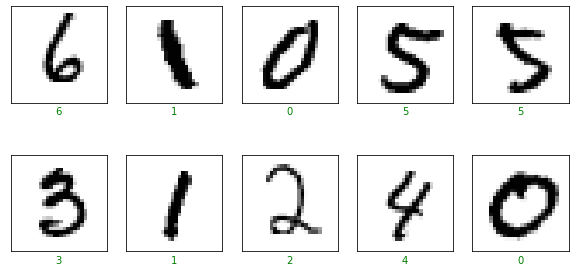

In [4]:
(x_train,y_train), (x_test, y_test) = load_data()
plot_random_examples(x_train,y_train).show()

In [5]:
#let's create our neural network
#pass a list of layers
net=NeuralNetwork([784,128,128,10]) #just 2 layers
net.info()

Input Features: 784
Number of Classes: 10
Hidden Layers:
--------------
Layer 1, Units 128
Layer 2, Units 128
--------------
Number of parameters: 118282


In [6]:
batch_size = 120
epochs = 5
steps_per_epoch = int(x_train.shape[0]/batch_size)
lr = 3e-3

print('Steps per epoch:', steps_per_epoch)

Steps per epoch: 500


In [7]:
history = net.train(
    x_train, y_train,
    x_test, y_test,
    epochs, steps_per_epoch,
    batch_size, lr
)

Epoch0...........Val Acc: 0.8029
Epoch1...........Val Acc: 0.8377
Epoch2...........Val Acc: 0.8504
Epoch3...........Val Acc: 0.8601
Epoch4...........Val Acc: 0.8662


### Conclusions

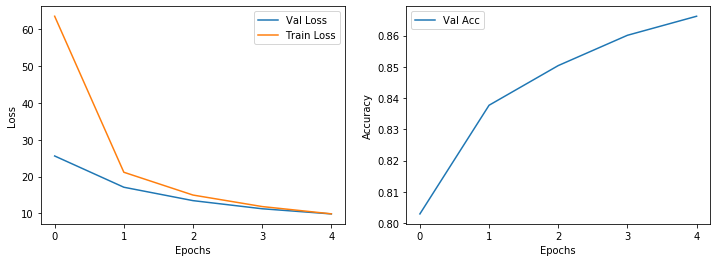

In [9]:
plot_results(history).show()

In [10]:
preds = net.predict(x_test)

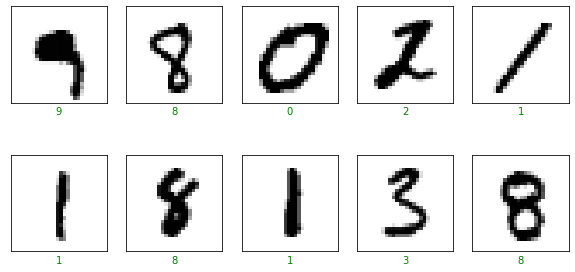

In [11]:
plot_random_examples(x_test, y_test, preds.numpy()).show()